# Day 10: Feature Engineering, Model Evaluation & Mini Project

This notebook covers feature engineering techniques, model evaluation methods, and includes a mini project.

## 1. Setting up the Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

# Set random seed for reproducibility
np.random.seed(42)

## 2. Feature Engineering

In [2]:
# Load Titanic dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
titanic_data = pd.read_csv(url)

print("Sample of the dataset:")
print(titanic_data.head())

print("\nDataset info:")
print(titanic_data.info())

Sample of the dataset:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0

## 3. Data Preprocessing and Feature Engineering

In [3]:
# Handle missing values
def preprocess_data(df):
    # Create copy
    df = df.copy()
    
    # Fill missing values
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    
    # Feature engineering
    # 1. Extract title from name
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    title_mapping = {
        'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4,
        'Dr': 5, 'Rev': 5, 'Col': 5, 'Major': 5, 'Mlle': 2,
        'Countess': 5, 'Ms': 2, 'Lady': 5, 'Jonkheer': 5,
        'Don': 5, 'Dona': 5, 'Mme': 3, 'Capt': 5, 'Sir': 5
    }
    df['Title'] = df['Title'].map(title_mapping)
    
    # 2. Family size
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # 3. Is alone
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # 4. Age bands
    df['AgeBand'] = pd.cut(df['Age'], 5)
    
    # 5. Fare bands
    df['FareBand'] = pd.qcut(df['Fare'], 4)
    
    # Select features for model
    features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 
                'Title', 'FamilySize', 'IsAlone']
    
    return df[features], df['Survived']

# Prepare data
X, y = preprocess_data(titanic_data)

# Split features into numeric and categorical
numeric_features = ['Age', 'Fare', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'IsAlone']

# Create preprocessing pipelines
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse=False)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Print results
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       105
           1       0.81      0.78      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179



c:\Users\Nandhan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## 4. Feature Selection

c:\Users\Nandhan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Feature ranking:
1. Fare (0.254728)
2. Age (0.230355)
3. Sex_male (0.189995)
4. Pclass_3 (0.070819)
5. FamilySize (0.064154)
6. Title_3 (0.057956)
7. Title_2 (0.043815)
8. Embarked_S (0.022487)
9. Title_4 (0.018421)
10. Pclass_2 (0.017227)
11. IsAlone_1 (0.014665)
12. Embarked_Q (0.009037)
13. Title_5 (0.006343)


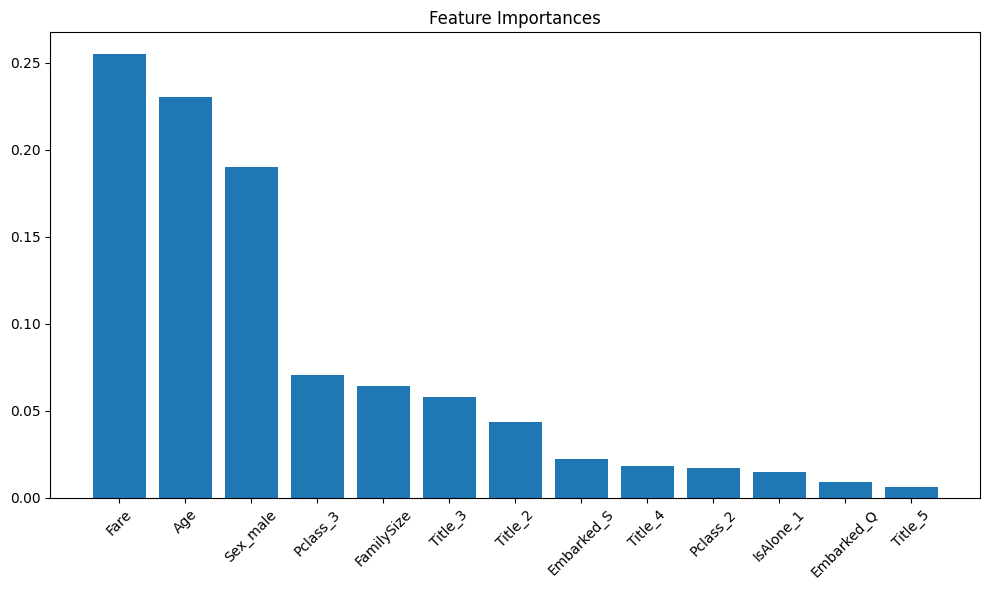

In [4]:
# Feature importance from Random Forest
feature_names = (numeric_features + 
                [f"{feat}_{val}" for feat, vals in 
                 zip(categorical_features, 
                     categorical_transformer.fit(X_train[categorical_features]).categories_)
                 for val in vals[1:]])

importances = clf.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for f in range(len(importances)):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

## 5. Model Evaluation

In [ ]:
# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X, y, cv=cv)

print("Cross-validation scores:", cv_scores)
print("Average CV score: %0.3f (+/- %0.3f)" % (cv_scores.mean(), cv_scores.std() * 2))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 6. Model Comparison

In [ ]:
# Compare different models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier()
}

results = []

for name, model in models.items():
    # Create pipeline with model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Cross-validation
    cv_scores = cross_val_score(pipeline, X, y, cv=5)
    
    # Store results
    results.append({
        'Model': name,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'CV Scores': cv_scores
    })

# Display results
results_df = pd.DataFrame(results)
print("Model Comparison:")
print(results_df[['Model', 'CV Mean', 'CV Std']])

# Plot comparison
plt.figure(figsize=(10, 6))
plt.boxplot([r['CV Scores'] for r in results], labels=[r['Model'] for r in results])
plt.title('Model Comparison - Cross-validation Scores')
plt.ylabel('Accuracy')
plt.show()

## 7. Bias-Variance Tradeoff Analysis

In [ ]:
def analyze_learning_curve(estimator, X, y, title):
    from sklearn.model_selection import learning_curve
    
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=train_sizes
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, test_mean, label='Cross-validation score')
    
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std,
                     test_mean + test_std, alpha=0.1)
    
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.title(f'Learning Curve - {title}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Analyze learning curves for both models
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    analyze_learning_curve(pipeline, X, y, name)

## 8. Model Deployment and Prediction

In [ ]:
def predict_survival(model, preprocessor, passenger_data):
    # Create DataFrame with single passenger
    passenger_df = pd.DataFrame([passenger_data])
    
    # Preprocess the data
    processed_data = preprocessor.transform(passenger_df)
    
    # Make prediction
    prediction = model.predict(processed_data)
    probability = model.predict_proba(processed_data)
    
    return prediction[0], probability[0]

# Example passenger
example_passenger = {
    'Pclass': 1,
    'Sex': 'female',
    'Age': 25,
    'Fare': 50,
    'Embarked': 'S',
    'Title': 2,  # Miss
    'FamilySize': 1,
    'IsAlone': 1
}

# Get best model from comparison
best_model = clf.named_steps['classifier']
best_preprocessor = clf.named_steps['preprocessor']

# Make prediction
prediction, probability = predict_survival(best_model, best_preprocessor, example_passenger)

print("Prediction for example passenger:")
print(f"Survival: {'Yes' if prediction == 1 else 'No'}")
print(f"Probability of survival: {probability[1]:.2f}")